<a href="https://colab.research.google.com/github/mitesh98/Quora_Question_Pair_Similarity/blob/master/Question_Pair_Similarity_Upto_Basic_Featurization_Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quora Question Pairs
# 1. Business Problem
**1.1 Description**

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


Credits: Kaggle

**Problem Statement**
*   Identify which questions asked on Quora are duplicates of questions that have already been asked.
*  This could be useful to instantly provide answers to questions that have already been answered.
*  We are tasked with predicting whether a pair of questions are duplicates or not.







**1.2 Sources/Useful Links**

**Source** : https://www.kaggle.com/c/quora-question-pairs 





# 1.3 Real world/Business Objectives and Constraints

1.   The cost of a mis-classification can be very high.

2.   You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.

3.   No strict latency concerns.

4.   Interpretability is partially important.




# 2. Machine Learning Probelm
# 2.1 Data
- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

# 3. Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# 3.1 Reading data and basic stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/train.csv' 'train.csv'

In [ ]:
data=pd.read_csv('train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

1. id: Looks like a simple rowID

2. qid{1, 2}: The unique ID of each question in the pair

3. question{1, 2}: The actual textual contents of the questions.

4. is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

# 3.2.1 Distribution of data points among output classes

*   Number of duplicate(smilar) and non-duplicate(non similar) questions





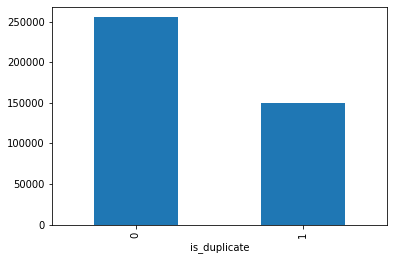

In [ ]:
data.groupby("is_duplicate")["id"].count().plot.bar()

In [ ]:
n=len(data)
x=data["is_duplicate"].value_counts()[0]
y=data["is_duplicate"].value_counts()[1]
print("Total No of Question Pair = ",n)
print("%age of is_duplicate=0  Pair = ",round(100*x/n,2))
print("%age of of is_duplicate=1 Pair = ",round(100*y/n,2))

Total No of Question Pair =  404290
%age of is_duplicate=0  Pair =  63.08
%age of of is_duplicate=1 Pair =  36.92


**3.2.2 Number of unique questions**

In [ ]:
List_of_qids=[]
List_of_qids=data["qid1"].tolist()
List_of_qids.extend(data["qid2"].tolist())
List_of_unique_qids=list(set(List_of_qids))
print("Total No of unique question = ",len(List_of_unique_qids))

Total No of unique question =  537933


In [ ]:
from collections import Counter
count=Counter(List_of_qids)
type(count)
qids_morethan_onetime=list(set(k for k,v in count.items() if v>1))
qids_morethan_onetime=list(set(k for k,v in count.items() if v>1))
print("No of question appears more than one time = ",len(qids_morethan_onetime))
print("% question appears more than one time = ",round(100*len(qids_morethan_onetime)/len(List_of_unique_qids),2))

No of question appears more than one time =  111780
% question appears more than one time =  20.78


In [ ]:
k=count.most_common(1)
print("Most repeated qid is '",k[0][0],"' no of repeatation = ",k[0][1])

Most repeated qid is ' 2559 ' no of repeatation =  157


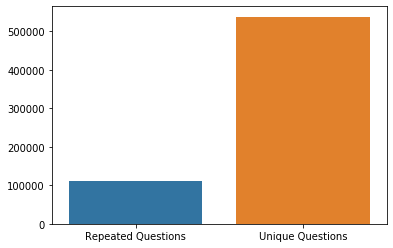

In [ ]:
y=[len(qids_morethan_onetime),len(List_of_unique_qids)]
x=["Repeated Questions","Unique Questions"]
sns.barplot(x,y)
plt.show()

**3.2.3 Checking for Duplicates**

In [ ]:
pair_duplicates=data[["qid1","qid2","is_duplicate"]].groupby(["qid1","qid2"]).count()
print("No of duplicates = ",pair_duplicates.shape[0]-data.shape[0])

No of duplicates =  0


**3.2.4 Number of occurrences of each question**

Text(0, 0.5, 'Number of questions')

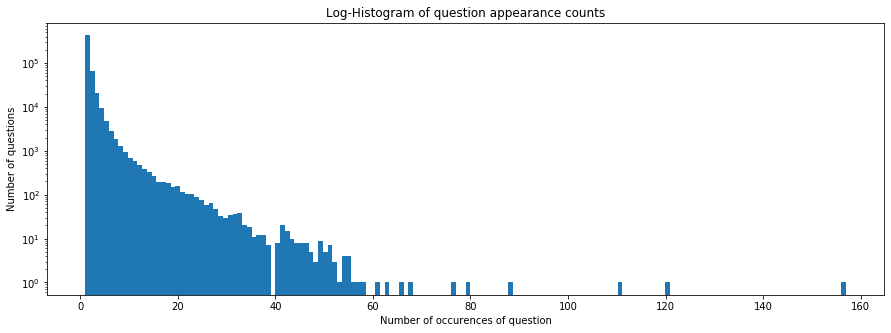

In [ ]:
Series_of_qids=pd.Series(List_of_qids)
x=Series_of_qids.value_counts()
plt.figure(figsize=(15,5))
plt.hist(x,bins=160)
plt.yscale('log',nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

**3.2.5 Checking for NULL values**

In [ ]:
nan_rows=data[data.isnull().any(axis=1)]
print(nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


**Observation :**

1.There are 2 rows with null values in question2


2.There are 1 row with null values in question1

In [ ]:
# Filling the null values with ' '
data=data.fillna('')
nan_rows=data[data.isnull().any(axis=1)]
print(nan_rows)


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# 3.3 Basic Feature Extraction (before cleaning)


Let us now construct a few features like:


*   **freq_qid1** = Frequency of qid1's

*   **freq_qid2**  = Frequency of qid2's

* **q1len** = Length of q1

* **q2len** = Length of q2

* **q1_n_words** = Number of words in Question 1

* **q2_n_words** = Number of words in Question 2

* **word_Common** = (Number of common unique words in Question 1 and Question 2)

* **word_Total** =(Total num of words in Question 1 + Total num of words in Question 2)

* **word_share** = (word_common)/(word_Total)

* **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2

* **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2




In [ ]:
#to create a new column which counts the number of rows in each group
data['freq_qid1']=data.groupby('qid1')['qid1'].transform('count')
data['freq_qid2']=data.groupby('qid2')['qid2'].transform('count')
data['q1len']=data['question1'].str.len() #lenght of the whole question
data['q2len']=data['question2'].str.len()
data['q1_n_words']=data['question1'].apply(lambda row:len(row.split(" "))) #no of words
data['q2_n_words']=data['question2'].apply(lambda row:len(row.split(" ")))

def normalized_word_Common(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0*(len(w1)+len(w2))
data['word_Total'] = data.apply(normalized_word_Total, axis=1)

def normalized_word_Share(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0*len(w1 & w2)/(len(w1)+len(w2))
data['word_Share'] = data.apply(normalized_word_Share, axis=1)

data['freq_q1+q2']=data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2']=data['freq_qid1']-data['freq_qid2']

data.head()


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


**3.3.1 Analysis of some of the extracted features**

In [ ]:
print("Minimum no of word in question of qustion1 : " , min(data['q1_n_words']))
print("Minimum no of word in question of qustion2 : " , min(data['q2_n_words']))

print("Number of Questions with minimum length [question1] :",data[data['q1_n_words']==1].shape[0])
print("Number of Questions with minimum length [question2] :",data[data['q2_n_words']==1].shape[0])

Minimum no of word in question of qustion1 :  1
Minimum no of word in question of qustion2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


**3.3.1.1 Feature: word_share**

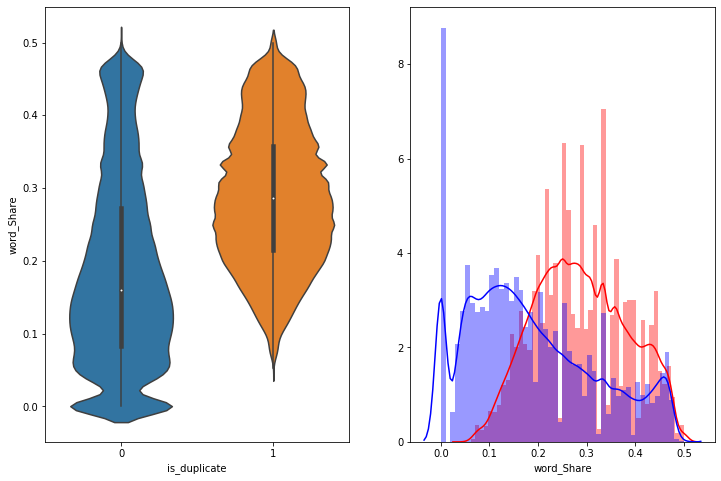

In [ ]:
#subplot(nrows, ncols, index, **kwargs)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Share',data=data)

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1]['word_Share'],label="1",color="red")
sns.distplot(data[data['is_duplicate']==0]['word_Share'],label="0",color="blue")
plt.show()

* The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity

* The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

**3.3.1.2 Feature: word_Common**

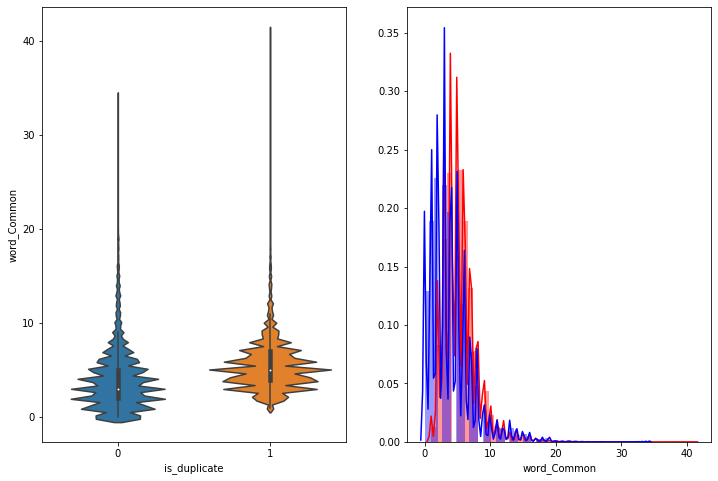

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=data)

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1]['word_Common'],label="1",color="red")
sns.distplot(data[data['is_duplicate']==0]['word_Common'],label="0",color="blue")
plt.show()

**Observation :** The distributions of the word_Common feature in similar and non-similar questions are highly overlapping